In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import pandas as pd

In [2]:
url_base = "https://storage.gra.cloud.ovh.net/v1/AUTH_32c5d10cb0fe4519b957064a111717e3/bso_dump"
url = f"{url_base}/bso-clinical-trials.jsonl.gz"
df = pd.read_json(url, lines=True)

In [3]:
df = df[df.all_sources.apply(lambda x: "clinical_trials" in x or "euctr" in x)]
len(df)

43954

In [4]:
df.lead_sponsor_type.value_counts()

lead_sponsor_type
academique    23566
industriel    20382
Name: count, dtype: int64

In [5]:
mapping = pd.read_csv("https://raw.githubusercontent.com/dataesr/bso-clinical-trials/main/bsoclinicaltrials/server/main/bso-lead-sponsors-mapping.csv")

In [6]:
list_rors = [r.split("/")[-1] for r in mapping.ror.unique() if (r==r) and len(r.split("/")[-1])==9]
len(list_rors)

102

In [7]:
df_completed_intervention_all = df[(df.status_simplified=="Completed") & (df.study_type=="Interventional")]
df_completed_intervention = df[(df.status_simplified=="Completed") & (df.study_type=="Interventional") & (df.lead_sponsor_type=="academique")]
mycols = ["lead_sponsor", "study_completion_year", "NCTId", "eudraCT", "study_type", "status_simplified",
          "acronym", "title", "has_results_or_publications", "has_results_or_publications_within_1y",
          "has_results_or_publications_within_3y", "intervention_type"]
df2 = df_completed_intervention[mycols]

In [8]:
excluded_rors = [
    "02n6c9837", # Sanofi
    "02xnj2427"  # Hôpital de Ville-Évrard
]

In [9]:
df_intervention = df[(df.study_type=="Interventional") & (df.lead_sponsor_type=="academique")]
dd_perim = pd.merge(df_intervention[mycols], mapping, left_on="lead_sponsor", right_on="sponsor", indicator=True, how="inner")
dd_perim_ror = dd_perim[dd_perim.ror.apply(lambda x:isinstance(x, str) and "ror.org/" in x)]
dd_perim_ror["ror_simple"] = dd_perim_ror.ror.apply(lambda x:x.split("/")[-1])
dd_perim_ror.ror_simple.value_counts().head(65)
df_perimetre = pd.DataFrame(dd_perim_ror.ror_simple.value_counts().head(64)).reset_index() # 10 essais
df_perimetre.columns = ["ror", "nb"]
df_perimetre = df_perimetre[df_perimetre.ror.apply(lambda x:x not in excluded_rors)]
df_name = dd_perim_ror[["ror_simple", "sponsor_normalized"]].drop_duplicates()
df_perimetre2 = pd.merge(df_perimetre, df_name, left_on="ror", right_on="ror_simple", how="left")
df_perimetre2[["ror", "nb", "sponsor_normalized"]].to_csv("../publipostage/perimetre.csv", index=False)

/tmp/ipykernel_373492/1866012524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_perim_ror["ror_simple"] = dd_perim_ror.ror.apply(lambda x:x.split("/")[-1])


In [10]:
rors_to_compute = df_perimetre.ror.to_list()

In [11]:
dd = pd.merge(df2, mapping, left_on="lead_sponsor", right_on="sponsor", indicator=True, how="inner")

In [12]:
dd._merge.value_counts()

_merge
both          6304
left_only        0
right_only       0
Name: count, dtype: int64

In [13]:
dd_ror = dd[dd.ror.apply(lambda x:isinstance(x, str) and "ror.org/" in x)]

In [14]:
dd_ror["ror_simple"] = dd_ror.ror.apply(lambda x:x.split("/")[-1])

/tmp/ipykernel_373492/1755542769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_ror["ror_simple"] = dd_ror.ror.apply(lambda x:x.split("/")[-1])


In [15]:
SIZE = 22
SMALL_SIZE=18
plt.rc("font", size=SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=SIZE)     # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SIZE)    # legend fontsize
plt.rc("figure", titlesize=SIZE)   # fontsize of the figure title

In [16]:
cle_false = "SANS communication\nidentifiée"
cle_true = "AVEC communication\nidentifiée"

LAST_YEAR = 2022

def analyze_global(df_etab):
    ans = {"global": {}, "10Y": {}, "10Ydrug": {}}
    d_g = pd.DataFrame(df_etab.has_results_or_publications.value_counts(dropna=False))
    d_g_10 = pd.DataFrame(df_etab[(df_etab.study_completion_year > LAST_YEAR - 10) & (df_etab.study_completion_year <= LAST_YEAR)].has_results_or_publications.value_counts(dropna=False))
    d_g_10_drug = pd.DataFrame(df_etab[(df_etab.study_completion_year > LAST_YEAR - 10) & (df_etab.study_completion_year <= LAST_YEAR) & (df_etab.intervention_type == "DRUG")].has_results_or_publications.value_counts(dropna=False))
    try:
        ans["global"][cle_true] = d_g[d_g.index==True].values[0][0]
    except Exception as e:
        print(e)
        ans["global"][cle_true] = 0
    try:
        ans["global"][cle_false] = d_g[d_g.index==False].values[0][0]
    except Exception as e:
        print(e)
        ans["global"][cle_false] = 0
    assert(ans["global"][cle_false] + ans["global"][cle_true]) == len(df_etab)
    try:
        ans["10Y"][cle_true] = d_g_10[d_g_10.index==True].values[0][0]
    except Exception as e:
        print(e)
        ans["10Y"][cle_true] = 0
    try:
        ans["10Y"][cle_false] = d_g_10[d_g_10.index==False].values[0][0]
    except Exception as e:
        print(e)
        ans["10Y"][cle_false] = 0
    try:
        ans["10Ydrug"][cle_true] = d_g_10_drug[d_g_10_drug.index==True].values[0][0]
    except Exception as e:
        print(e)
        ans["10Ydrug"][cle_true] = 0
    try:
        ans["10Ydrug"][cle_false] = d_g_10_drug[d_g_10_drug.index==False].values[0][0]
    except Exception as e:
        print(e)
        ans["10Ydrug"][cle_false] = 0
    return ans

In [17]:
def make_evolution(ror, df_tmp):
    df1Y = pd.DataFrame(df_tmp[(df_tmp.study_completion_year >= 2013) & (df_tmp.study_completion_year <= LAST_YEAR)].groupby("study_completion_year")["has_results_or_publications_within_1y"].mean()).reset_index()
    df1_3Y = df1Y
    years = df1_3Y.study_completion_year.tolist()
    rate1Y = df1_3Y.has_results_or_publications_within_1y.tolist()
    _, ax = plt.subplots(figsize=(9,9), dpi=100)
    width = 0.75  # the width of the bars
    rects1 = ax.bar([y for y in years], [100 * r for r in rate1Y], width, label="1 an", color=["#DB87C9"])
    ax.bar_label(rects1, labels = [f"{round(100*r)} %" for r in rate1Y], 
                 padding=3, 
                 fontsize=SMALL_SIZE)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xticks(years)
    ax.set_xticklabels([str(y).replace(".0", "") for y in years], rotation="vertical", fontsize=SMALL_SIZE)
    ax.legend(loc="upper left")
    ax.set_xlabel("Année de clôture de l'essai clinique")
    ax.set_ylim(0, 100)
    plt.savefig(f"./../publipostage/{ror}/evolution_temporelle_essais_cliniques_{ror}.png", bbox_inches="tight", dpi=300)

In [27]:
def get_perc(stats):
    try:
        true_global = int(round(100 * stats["global"][cle_true] / (stats["global"][cle_false] + stats["global"][cle_true]), 0))
    except ZeroDivisionError:
        true_global = 0
    try:
        true_10Y = int(round(100 * stats["10Y"][cle_true] / (stats["10Y"][cle_false] + stats["10Y"][cle_true]), 0))
    except ZeroDivisionError:
        true_10Y = 0
    try:
        true_10Ydrug = int(round(100 * stats["10Ydrug"][cle_true] / (stats["10Ydrug"][cle_false] + stats["10Ydrug"][cle_true]), 0))
    except ZeroDivisionError:
        true_10Ydrug = 0
    return f"{true_global} %", f"{true_10Y} %", f"{true_10Ydrug} %"

In [19]:
print("france")
stat_france = analyze_global(df_completed_intervention_all)
print(get_perc(stat_france))

print("academique")
stat_academique = analyze_global(df_completed_intervention)
print(get_perc(stat_academique))

france
('54 %', '54 %', '76 %')
academique
('30 %', '31 %', '46 %')


In [20]:
df[["title", "acronym"]]

,title,acronym
0,Collection of SPOT EGMs And inTra-Cardiac Impe...,SATURN
1,"A Single-Arm, Open-Label, Phase 2 Study of Niv...",NaN
2,First Evaluation of Morphine Hydrochloride by ...,AEROMORPH1
3,Lung Ultrasound in Pediatric Acute Chest Syndrome,Lupacs
4,Prospective Evaluation of the Resection Margin...,MRP
...,...,...
45536,Three-Arm Randomized Phase II Clinical Study o...,NaN
45537,A Pilot Evaluation of the Safety and Efficacy ...,CXLMyopie
45538,"A Multicenter, Double-blind, Placebo-controlle...",DIAMOND
45539,"A Randomized, Parallel-Group, Multicentre, Ope...",NaN


In [21]:
def get_status(row):
    if row.has_results_or_publications_within_1y is False and row.has_results_or_publications_within_3y is False:
        return "\U0001f7E5"
    if row.has_results_or_publications_within_1y is False and row.has_results_or_publications_within_3y is True:
        return "\U0001f7E7"
    if row.has_results_or_publications_within_1y is True and row.has_results_or_publications_within_3y is True:
        return "\U0001f7E9"

def get_status_label(row):
    if row.has_results_or_publications_within_1y is False and row.has_results_or_publications_within_3y is False:
        return "rouge"
    if row.has_results_or_publications_within_1y is False and row.has_results_or_publications_within_3y is True:
        return "orange"
    if row.has_results_or_publications_within_1y is True and row.has_results_or_publications_within_3y is True:
        return "vert"

In [22]:
def clean_year(y):
    try:
        return str(int(y))
    except:
        return None

In [ ]:
def make_pie(ror, stats, pie_type):
    _, ax = plt.subplots(figsize=(9,9), dpi=100)
    total = stats[pie_type][cle_false] + stats[pie_type][cle_true]
    labels = [f"{stats[pie_type][cle_false]} essais cliniques sur {total}\nSANS communication identifiée",
             f"{stats[pie_type][cle_true]} essais cliniques sur {total}\nAVEC communication identifiée"]
    colors=["#FFF5BA", "#5A35BE"]
    values = [stats[pie_type][cle_false], stats[pie_type][cle_true]]
    a, b = values
    if (a == 0 and b == 0):
        return
    _, _, autotexts  = ax.pie(values, startangle=90, autopct="%1.0f%%", 
                 explode=(0.025, 0.025),
                 colors=colors)
    autotexts[1].set_color("white")
    ax.legend(labels=labels, bbox_to_anchor=(0.15,0.5), 
              loc="center right", fontsize=20, 
               bbox_transform=plt.gcf().transFigure)
    plt.savefig(f"./../publipostage/{ror}/repartition_essais_cliniques_{pie_type}_{ror}.png", bbox_inches="tight", dpi=300)

def make_data(ror):
    os.system(f"mkdir -p ./../publipostage/{ror}")
    df_tmp = dd_ror[dd_ror.ror_simple == ror].sort_values(by="study_completion_year")
    dx = pd.DataFrame(df_tmp.lead_sponsor.value_counts()).reset_index()
    dx.columns = ["variant", "nb_studies"]
    dx[["variant"]].to_csv(f"./../publipostage/{ror}/liste_variantes_noms_{ror}.csv", index=False, header=False, sep="£")
    df_tmp["status"] = df_tmp.apply(lambda row: get_status(row), axis=1)
    df_tmp["status_label"] = df_tmp.apply(lambda row: get_status_label(row), axis=1)
    cols = ["status", "status_label", "NCTId", "eudraCT", "study_completion_year", "title", "acronym", "has_results_or_publications_within_1y",
           "has_results_or_publications_within_3y", "has_results_or_publications", "intervention_type"]
    stats = analyze_global(df_tmp)
    global_stat = {"ror": ror}
    try:
        global_stat["sponsor_name"] = df_tmp.sponsor_normalized.values[0]
    except:
        print("skip " + ror)
        return
    global_stat["sponsor_article"] = "du"
    if global_stat["sponsor_name"][0] in ["A", "E", "I", "O", "U", "Y"]:
        global_stat["sponsor_article"] = "de l'"
    if global_stat["sponsor_name"].split(" ")[0].lower() in ["hospices", "hopitaux", "hôpitaux"]:
        global_stat["sponsor_article"] = "des"
    if global_stat["sponsor_name"].split(" ")[0].lower() in ["hopital", "hôpital"]:
        global_stat["sponsor_article"] = "de l'"
    if global_stat["sponsor_name"].split(" ")[0].lower() in ["clinique"]:
        global_stat["sponsor_article"] = "de la"
    a, b, c = get_perc(stats)
    global_stat["global_indicator"] = a
    global_stat["10Y_indicator"] = b
    global_stat["10Ydrug_indicator"] = c
    pd.DataFrame([global_stat]).to_csv(f"./../publipostage/{ror}/indicators_{ror}.csv", index=False)
    make_pie(ror, stats, "global")
    make_pie(ror, stats, "10Y")
    make_pie(ror, stats, "10Ydrug")
    make_evolution(ror, df_tmp)
    plt.close("all")
    df_tmp["study_completion_year"] = df_tmp["study_completion_year"].apply(lambda x:clean_year(x))
    df_liste_essais = df_tmp[cols]
    df_liste_essais.columns = ["statut", "status_label", "NCTId", "eudraCT", "completion_year", 
                               "clinical_trial_title", "acronym", 
                               "results_1y", "results_3y", "results", "intervention_type"]
    df_liste_essais.to_csv(f"./../publipostage/{ror}/liste_essais_cliniques_identifies_{ror}.csv", index=False)
    df_liste_essais.to_excel(f"./../publipostage/{ror}/liste_essais_cliniques_identifies_{ror}.xlsx", index=False)

[616, 407]
[398, 278]
[105, 96]
[354, 137]
[281, 101]
[37, 21]
[143, 62]
[101, 52]
[11, 3]
[213, 87]
[155, 60]
[22, 16]
[134, 71]
[84, 43]
[15, 18]
[240, 60]
[161, 37]
[30, 8]
[166, 47]
[91, 28]
[9, 10]
[134, 73]
[86, 57]
[15, 28]
[144, 58]
[103, 43]
[10, 6]
[192, 32]
[130, 26]
[22, 5]
[93, 20]
[61, 13]
[10, 3]
[85, 20]
[53, 18]
[6, 3]
[144, 28]
[96, 21]
[15, 6]
[75, 48]
[69, 34]
[19, 8]
[84, 62]
[61, 54]
[10, 7]
[74, 26]
[47, 16]
[6, 1]
[124, 19]
[88, 16]
[9, 5]
[69, 29]
[43, 23]
[8, 8]
[47, 26]
[27, 18]
[11, 11]
[68, 34]
[47, 23]
[1, 6]
[81, 27]
[60, 17]
[10, 4]
[95, 25]
[58, 16]
[8, 6]
[56, 21]
[37, 19]
[3, 2]
[89, 31]
[61, 24]
[10, 8]
[61, 28]
[46, 25]
[6, 11]
[68, 25]
[48, 17]
[10, 4]
[69, 25]
[59, 18]
[8, 1]
[37, 32]
[20, 22]
[7, 16]
[46, 56]
[23, 25]
[8, 16]
[64, 25]
[51, 20]
[13, 10]
[57, 28]
[35, 17]
[6, 6]
index 0 is out of bounds for axis 0 with size 0
[57, 7]
[47, 4]
[4, 0]
[33, 12]
[19, 9]
[2, 4]
index 0 is out of bounds for axis 0 with size 0
[23, 17]
[20, 13]
[2, 0]
inde

/home/alhote/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3229: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values


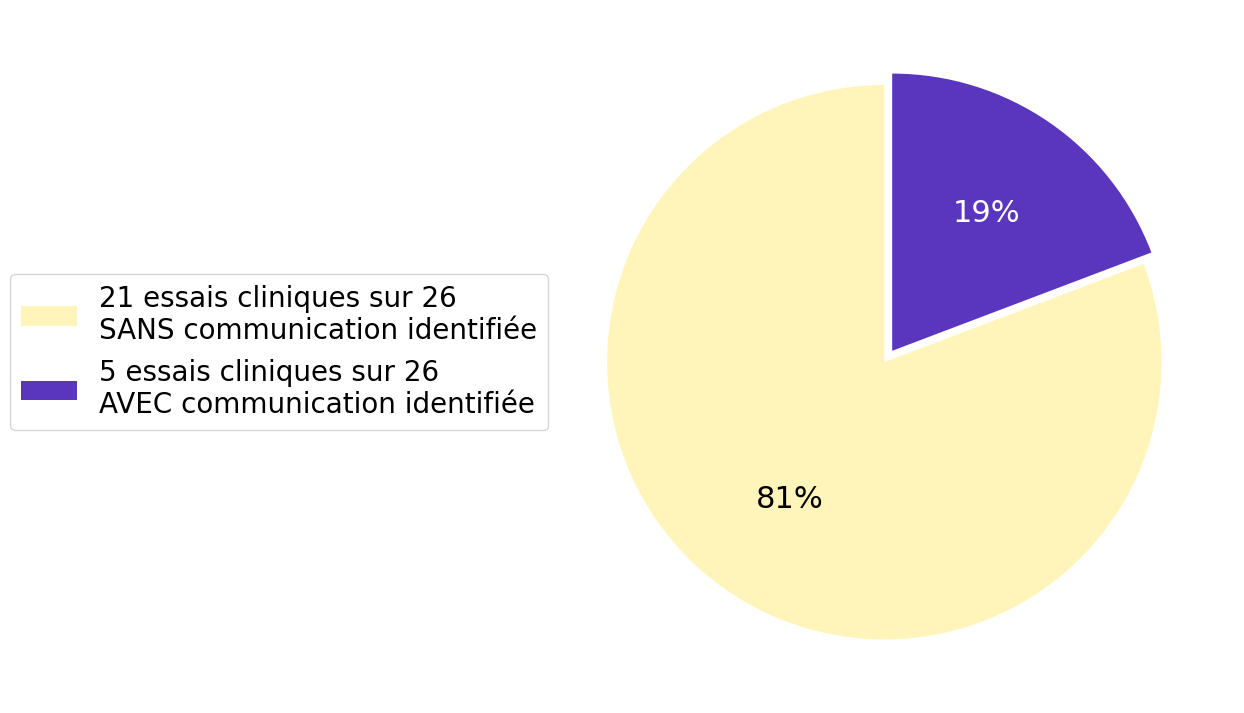

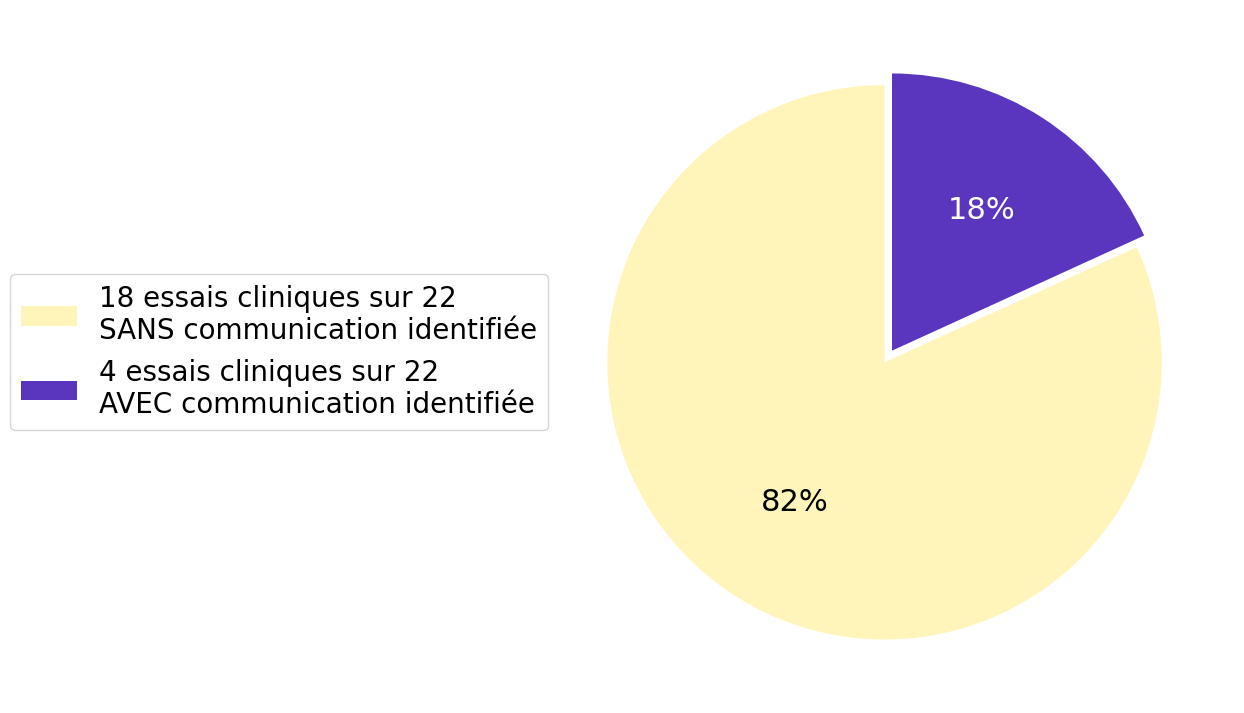

posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 900x900 with 1 Axes>

In [30]:
for ix, current_ror in enumerate(rors_to_compute):
    if current_ror in excluded_rors:
        continue
    make_data(current_ror)